# FROM 2D to 3D

## Import

In [2]:
import os
os.chdir("../../../")

In [3]:
import sys
import time

import numpy as np
import tensorflow as tf

import math
import random

from src.training.pose_3d import h36m
from src.training.pose_3d.linear_model import LinearModel
import glob
import h5py
from src.utils.pose import PoseConfig
from src.utils.pose import Pose2D
from src.utils.pose import Pose3D
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *

plotly.offline.init_notebook_mode(connected=True)

## Data visualisation for debug

In [1]:
class Visualization:

    @staticmethod
    def plot_3d(joints_3d):

        joints = joints_3d

        trace1 = go.Scatter3d(
            x=joints[:, 0],
            y=joints[:, 1],
            z=joints[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                line=dict(
                    color='rgba(200,200,200)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text= PoseConfig.NAMES
        )

        data = [trace1]
        
        camera = dict(
            up=dict(x=1, y=0, z=0),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=0, z=-2)
        )

        layout = go.Layout(
            scene=dict(
                xaxis=dict(nticks=4, range=[-1, 1], ),
                yaxis=dict(nticks=4, range=[-1, 1], ),
                zaxis=dict(nticks=4, range=[-1, 1], ),
                aspectmode="manual",
                aspectratio=dict(x=1, y=1, z=1)
            ),
            width=500,
            margin=dict(r=0, l=0, b=0, t=0)
        )

        fig = go.Figure(data=data, layout=layout)

        fig['layout'].update(
            scene=dict(camera=camera),
            title="cam"
        )

        plotly.offline.iplot(fig, filename='simple-3d-scatter')

        
    def plot_gt_vs_pred(gt_pos, pred_pos):

        trace1 = go.Scatter3d(
            x=gt_pos[:, 0],
            y=gt_pos[:, 1],
            z=gt_pos[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        trace2 = go.Scatter3d(
            x=pred_pos[:, 0],
            y=pred_pos[:, 1],
            z=pred_pos[:, 2],
            mode='markers',
            marker=dict(
                color='rgb(327, 127, 57)',
                size=5,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1, trace2]

        camera = dict(
            up=dict(x=1, y=0, z=0),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=0, z=-2)
        )

        layout = go.Layout(
            scene=dict(
                xaxis=dict(nticks=4, range=[-1, 1], ),
                yaxis=dict(nticks=4, range=[-1, 1], ),
                zaxis=dict(nticks=4, range=[-1, 1], ),
                aspectmode="manual",
                aspectratio=dict(x=1, y=1, z=1)
            ),
            width=500,
            margin=dict(r=0, l=0, b=0, t=0)
        )

        fig = go.Figure(data=data, layout=layout)

        fig['layout'].update(
            scene=dict(camera=camera),
            title="cam"
        )

        plotly.offline.iplot(fig, filename='simple-3d-scatter')



## Build the dataset

In [4]:
"""
Returns a dictionary with keys k=(subject, action, seqname) and the joint position as value
"""
def read_data(bpath, subjects, actions):

    dim=3

    data = {}

    # permutation from h36m joint order to our system
    JOINTS_PERM = [15,17,25,18,26,19,27,6,1,7,2,8,3]
    # permutation <x,y> on the first 2 dim and the depth in the third axis
    AXIS_PERM = [0,2,1]

    for subj in subjects:
        for action in actions:

            dpath = os.path.join(bpath, 'S{0}'.format(subj), 'MyPoses/{0}D_positions'.format(dim),
                                 '{0}*.h5'.format(action))

            fnames = glob.glob(dpath)

            loaded_seqs = 0
            for fname in fnames:
                seqname = os.path.basename(fname)

                # This rule makes sure SittingDown is not loaded when Sitting is requested
                if action == "Sitting" and seqname.startswith("SittingDown"):
                    continue

                # This rule makes sure that WalkDog and WalkTogeter are not loaded when
                # Walking is requested.
                if seqname.startswith(action):
                    # print( fname )
                    loaded_seqs = loaded_seqs + 1

                    with h5py.File(fname, 'r') as h5f:
                        poses = h5f['{0}D_positions'.format(dim)][:]

                    poses = poses.T
                    poses = poses.reshape((-1,32,3))
                    poses = poses[:, JOINTS_PERM, :][:,:,AXIS_PERM]
                    data[(subj, action, seqname)] = poses

            if dim == 2:
                assert loaded_seqs == 8, "Expecting 8 sequences, found {0} instead".format(loaded_seqs)
            else:
                assert loaded_seqs == 2, "Expecting 2 sequences, found {0} instead".format(loaded_seqs)

    return data

In [9]:
"""
Return a tuple of numpy array with :
1.- record's features corresponding to a normalized 2D pose
2.- value corresponding to the third dimension to recover (mu at 0)
Both rotation in radian
"""
def process_record(joints, subject_rot, camera_rot, has_symetry):

    leftToRight = {1:2,3:4,5:6,7:8,9:10,11:12}
    joints = joints.copy()
    
    # top/bottom reversed (in numpy array y=0 at the top)
    joints[:, 1] = -joints[:, 1]

    # symetry on X axis
    if has_symetry:
        joints[:, 0] = joints[:, 0] * (-1)
        joints_sym = joints.copy()
        for (leftId, rightId) in leftToRight.items():
            joints_sym[leftId,:]  = joints[rightId, :]
            joints_sym[rightId,:] = joints[leftId, :]
        joints = joints_sym
        
    center_hip = (joints[PoseConfig.L_HIP,:] + joints[PoseConfig.R_HIP,:])/2.0
    
    joints[:,:] = joints[:,:] - center_hip

    rot_1 = np.array([[math.cos(subject_rot), 0, math.sin(subject_rot)], [0, 1, 0], [-math.sin(subject_rot),0,math.cos(subject_rot)]])
    rot_2 = np.array([[1, 0, 0], [0, math.cos(camera_rot), -math.sin(camera_rot)],[0, math.sin(camera_rot),math.cos(camera_rot)]])

    for i in range(PoseConfig.get_total_joints()):
        joints[i,:] = np.matmul(rot_2, np.matmul( rot_1, joints[i,:] ) )

    return joints


In [10]:
def process_dataset(h36_data, jumping_window = 1, total_rotations = 4, symetric_ratio = 0.7):

    data = []

    for scenes in h36_data.values():

        for frameId in range(0, scenes.shape[0], jumping_window):

            scene = scenes[frameId]
            
            is_sym = random.random() < symetric_ratio
            data.append(process_record(scene, 0, 0, is_sym))
            
            for i in range(total_rotations):
                
                subject_rot = random.random()*(2*math.pi)
                camera_rot = 0
                is_sym = random.random() < symetric_ratio
                
                data.append(process_record(scene, subject_rot, camera_rot, is_sym))
                            
    return np.array(data)
            

=================== head


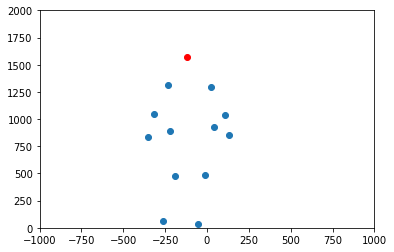

=================== leftShoulder


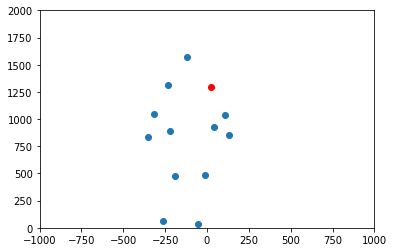

=================== rightShoulder


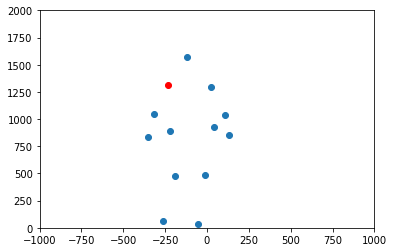

=================== leftElbow


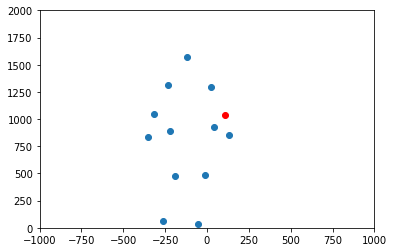

=================== rightElbow


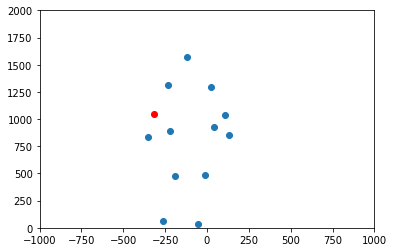

=================== leftWrist


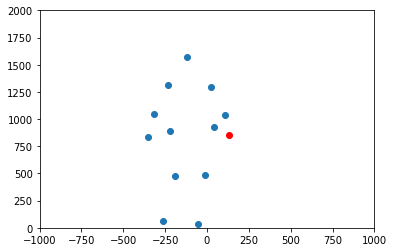

=================== rightWrist


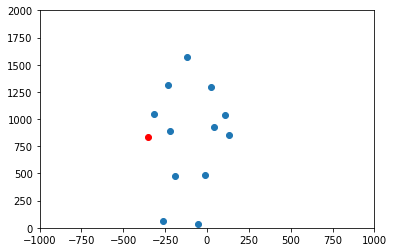

=================== leftHip


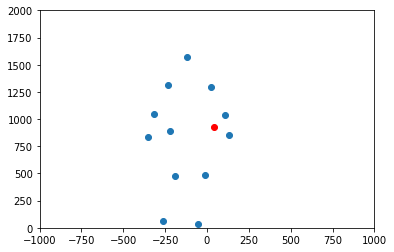

=================== rightHip


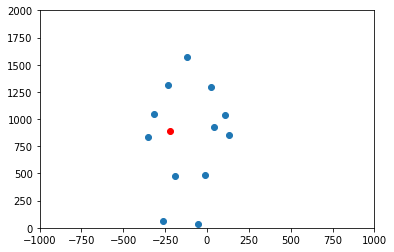

=================== leftKnee


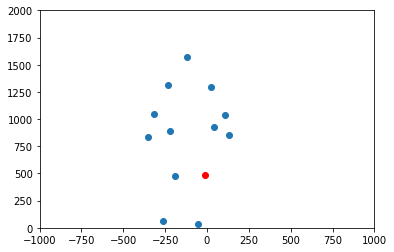

=================== rightKnee


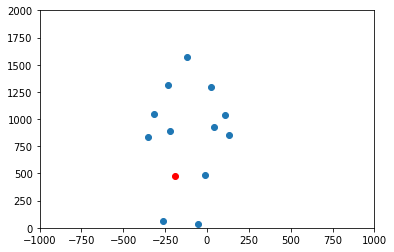

=================== leftAnkle


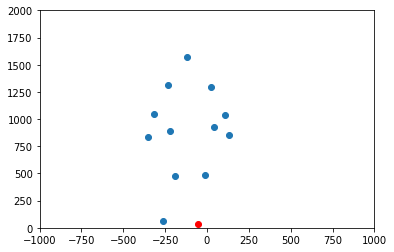

=================== rightAnkle


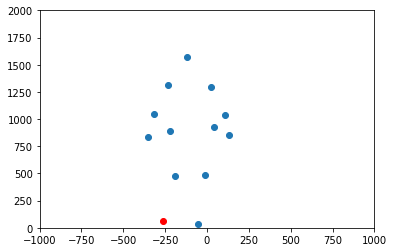

In [11]:
data = read_data("dataset/human36M/data/", [1], ["Directions"])
frame_id = 0
joints = data[(1,'Directions','Directions 1.h5')][frame_id]

for i in range(PoseConfig.get_total_joints()):

    print("=================== "+PoseConfig.NAMES[i])

    plt.scatter(x=joints[i,0], y=joints[i,1], c='r')
    axes = plt.gca()
    axes.set_xlim([-1000,1000])
    axes.set_ylim([0,2000])

    other_joints = [joint_id for joint_id in range(PoseConfig.get_total_joints()) if joint_id != i]
    plt.scatter(x=joints[other_joints,0],y=joints[other_joints,1])
    plt.show()
    

In [13]:
data = read_data("dataset/human36M/data/", [1], ["Directions"])
frame_id = 1
joints = data[(1,'Directions','Directions 1.h5')][frame_id]
joints = joints.copy()

joints[:,:] -= joints[:,:].min()
joints[:,:] /= joints[:,:].max()
joints[:,:] = joints[:,:]*2-1


jointsList = [process_record(joints, 0, 0, False), 
          process_record(joints, 0, 0, True),
          process_record(joints, math.pi/3, 0, False), 
          process_record(joints, math.pi/3, 0, False)]

for joints in jointsList:
    Visualization.plot_3d(joints)
    

In [14]:
data_dir = "dataset/human36M/data/"

actions = ["Directions","Discussion","Eating","Greeting","Phoning","Photo","Posing","Purchases",
           "Sitting","SittingDown","Smoking","Waiting","WalkDog","Walking","WalkTogether"]

number_of_actions = len(actions)

TRAIN_SUBJECTS = [1,5,6,7,8]
TEST_SUBJECTS = [9,11]

trainset = read_data( data_dir, TRAIN_SUBJECTS, actions)
trainset = process_dataset(trainset)
print("trainset done!")
testset = read_data( data_dir, TEST_SUBJECTS, actions)
testset = process_dataset(testset)
print("testset done!")

trainset done!
testset done!


In [15]:
np.save("dataset/human36M/processed_data/train", trainset)
np.save("dataset/human36M/processed_data/test", testset)

## Train the model

In [4]:
trainset = np.load("dataset/human36M/processed_data/train.npy")
testset = np.load("dataset/human36M/processed_data/test.npy")

In [5]:
def to_network_data(dataset):
    
    # dataset centered on hip center
    dataset = dataset.copy()
    widths = np.expand_dims(dataset[:,:,0].max(1) - dataset[:,:,0].min(1),1)
    heights = np.expand_dims(dataset[:,:,1].max(1) - dataset[:,:,1].min(1),1)
    bbox_size = np.concatenate([widths, heights],axis=1).max(1)
    
    features = []
    values = []
    
    for i in range(dataset.shape[0]):
        
        features.append( ((dataset[i,:,:2]-dataset[i,:,:2].min(0))/bbox_size[i]).reshape(-1) )
        
        values.append(dataset[i,:,2]/bbox_size[i])
    
    return np.array(features), np.array(values)


In [20]:
rnd_ids = random.choices(range(testset.shape[0]))
test_feats, test_values = to_network_data(testset[rnd_ids,:,:])
test_record = np.concatenate([test_feats.reshape(-1,13,2)[0,:,:], np.expand_dims(test_values[0,:], 1)], axis=1)
Visualization.plot_3d(test_record)

In [22]:
train_feats, train_values = to_network_data(trainset)

In [6]:
test_feats, test_values = to_network_data(testset)

In [7]:
class BatchProvider:
    
    
    def __init__(self, features, values, batch_size):
        
        self.features = features[:-(features.shape[0]%batch_size),:]
        self.values = values[:-(values.shape[0]%batch_size)]
        self.batch_size = batch_size
    
    
    def shuffle(self):
        rndIds = [i for i in range(self.features.shape[0])]
        random.shuffle(rndIds)          
        self.features = self.features[rndIds, :]
        self.values = self.values[rndIds, :]
        
        
    def size(self):
        return int(self.features.shape[0]/self.batch_size)
    
    
    def get_batch(self, batch_id):
            
        batch_feats = self.features[batch_id*self.batch_size:(batch_id+1)*self.batch_size,:]
        batch_values = self.values[batch_id*self.batch_size:(batch_id+1)*self.batch_size,:]
        
        return (batch_feats, batch_values)
        

In [37]:
tf.reset_default_graph()
config = tf.ConfigProto()
session = tf.Session(config=config)

In [38]:
linear_size=1024
num_layers=2
residual=True
batch_norm=False
max_norm=False
batch_size=64
learning_rate = 1e-3
path_to_model = "dataset/human36M/processed_data/v2/"

model = LinearModel(
            linear_size,
            num_layers,
            residual,
            batch_norm,
            max_norm,
            batch_size,
            learning_rate,
            path_to_model,
            dtype=tf.float32)


In [39]:
init = tf.global_variables_initializer()
session.run(init)

In [28]:
def train(session, model, trainset, testset, total_epochs, dropout, save_dir):
    
    test_every_n_batches = 10
    
    batchpro_train = BatchProvider(train_feats, train_values, model.batch_size)
    batchpro_train.shuffle()
    
    batchpro_test = BatchProvider(test_feats, test_values, model.batch_size)
    batchpro_test.shuffle()
    
    current_step = 0 
    
    print(current_step)
    
    for epoch in range(total_epochs):
        
        for batch_id in range(batchpro_train.size()):
            
            feat, values = batchpro_train.get_batch(batch_id)
            
            _, _, lr_summary, _ = model.step(session, feat, values, dropout)
            model.train_writer.add_summary(lr_summary, current_step)
            
            if (batch_id+1)% test_every_n_batches == 0: 
                batch_test_id = random.choices([i for i in range(batchpro_test.size())])[0]
                feat, values = batchpro_test.get_batch(batch_test_id)
                _, loss_summary, _ = model.step(session, feat, values, 1.0, False)
                model.train_writer.add_summary(loss_summary, current_step)
                
            current_step += 1
            
        model.saver.save(session, os.path.join(save_dir, 'checkpoint'), global_step=current_step )

In [ ]:
train(session, model, trainset, testset, 1000000, 0.8, "parameters/pose_3d/v2")

0


# Export the model

In [41]:
def export(session, outputFile="pose3d.pb", outputName="Output"):

    input_graph_def = tf.get_default_graph().as_graph_def()

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        session,
        input_graph_def,
        [outputName]
    )

    with tf.gfile.GFile(outputFile, "wb") as f:
        f.write(output_graph_def.SerializeToString())

In [42]:
export(session,"pose3d.pb", model.outputs.name.split(":")[0])

INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.
